# Sesión 10 — Variational Autoencoders (VAEs) con PyTorch

En esta sesión construiremos un **VAE** para MNIST.

**Objetivos**
- Implementar encoder que produce **μ(x)** y **log σ²(x)**
- Usar el **truco de reparametrización**
- Entrenar con pérdida: **reconstrucción + KL**
- Generar nuevos dígitos muestreando de **N(0, I)**

Pregunta guía: **¿Qué hace “generativo” a un VAE?**


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

torch.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [2]:
# Dataset: MNIST
try:
    from torchvision import datasets, transforms
    tfm = transforms.Compose([transforms.ToTensor()])
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=tfm)
    test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=tfm)
except Exception as e:
    raise RuntimeError(
        "No pude importar torchvision/MNIST. Instala torchvision o usa un entorno con torchvision disponible.\n"
        f"Error: {e}"
    )

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)


(60000, 10000)

/home/cesar/teaching/Python-ML/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


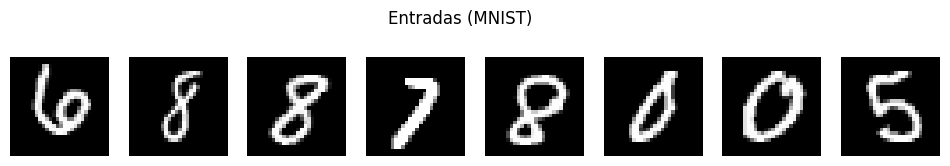

In [3]:
# Visualizar ejemplos
x, y = next(iter(train_loader))
x = x[:8]

fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(x[i,0], cmap="gray")
    ax.axis("off")
plt.suptitle("Entradas (MNIST)")
plt.show()

# Nota: las etiquetas se usarán SOLO para visualizar (no para entrenar).


## Modelo: VAE (latente 2D)

Para poder visualizar el espacio latente, usaremos `latent_dim = 2`.

Encoder produce:
- `mu` (media)
- `logvar` (log varianza)

Reparametrización:
\[
z = \mu + \sigma \odot \epsilon, \; \epsilon\sim\mathcal{N}(0,I)
\]


In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        # Encoder
        self.enc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
        )
        self.mu = nn.Linear(64, latent_dim)
        self.logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),  # salida en [0,1]
        )

    def encode(self, x):
        h = self.enc(x)
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        xhat = self.dec(z)
        return xhat.view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        xhat = self.decode(z)
        return xhat, mu, logvar, z

model = VAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sum(p.numel() for p in model.parameters())


435988

In [5]:
# Funciones de pérdida: Reconstrucción + KL

def vae_loss(x, xhat, mu, logvar, beta=1.0):
    # Reconstrucción: BCE por píxel (sum), promediada por batch
    rec = F.binary_cross_entropy(xhat, x, reduction="sum") / x.size(0)

    # KL(q(z|x) || N(0, I)) para Gaussiana diagonal
    kl = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1.0 - logvar) / x.size(0)

    return rec + beta * kl, rec.detach(), kl.detach()

# Pregunta: ¿qué ocurre si beta es demasiado grande?


In [6]:
def train_epoch(model, loader, beta=1.0):
    model.train()
    tot, tot_rec, tot_kl, n = 0.0, 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        optimizer.zero_grad()
        xhat, mu, logvar, _ = model(x)
        loss, rec, kl = vae_loss(x, xhat, mu, logvar, beta=beta)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        tot += loss.item() * bs
        tot_rec += rec.item() * bs
        tot_kl += kl.item() * bs
        n += bs
    return tot/n, tot_rec/n, tot_kl/n

@torch.no_grad()
def eval_epoch(model, loader, beta=1.0):
    model.eval()
    tot, tot_rec, tot_kl, n = 0.0, 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        xhat, mu, logvar, _ = model(x)
        loss, rec, kl = vae_loss(x, xhat, mu, logvar, beta=beta)

        bs = x.size(0)
        tot += loss.item() * bs
        tot_rec += rec.item() * bs
        tot_kl += kl.item() * bs
        n += bs
    return tot/n, tot_rec/n, tot_kl/n


In [7]:
# Entrenamiento
beta = 1.0
epochs = 8

hist = {"train_total": [], "train_rec": [], "train_kl": [],
        "test_total": [], "test_rec": [], "test_kl": []}

for ep in range(1, epochs+1):
    tr_total, tr_rec, tr_kl = train_epoch(model, train_loader, beta=beta)
    te_total, te_rec, te_kl = eval_epoch(model, test_loader, beta=beta)

    hist["train_total"].append(tr_total); hist["train_rec"].append(tr_rec); hist["train_kl"].append(tr_kl)
    hist["test_total"].append(te_total);  hist["test_rec"].append(te_rec);  hist["test_kl"].append(te_kl)

    print(f"Epoch {ep:02d} | train total={tr_total:.2f} (rec={tr_rec:.2f}, kl={tr_kl:.2f})"
          f" | test total={te_total:.2f} (rec={te_rec:.2f}, kl={te_kl:.2f})")


Epoch 01 | train total=214.16 (rec=210.37, kl=3.79) | test total=179.89 (rec=175.86, kl=4.03)
Epoch 02 | train total=173.27 (rec=168.84, kl=4.43) | test total=168.78 (rec=163.98, kl=4.79)
Epoch 03 | train total=166.69 (rec=161.80, kl=4.89) | test total=164.90 (rec=159.80, kl=5.10)
Epoch 04 | train total=162.88 (rec=157.72, kl=5.16) | test total=161.33 (rec=156.13, kl=5.20)
Epoch 05 | train total=159.86 (rec=154.54, kl=5.32) | test total=158.85 (rec=153.46, kl=5.39)
Epoch 06 | train total=157.65 (rec=152.21, kl=5.44) | test total=156.84 (rec=151.34, kl=5.50)
Epoch 07 | train total=155.97 (rec=150.44, kl=5.53) | test total=155.62 (rec=149.98, kl=5.65)
Epoch 08 | train total=154.70 (rec=149.09, kl=5.61) | test total=154.32 (rec=148.68, kl=5.64)


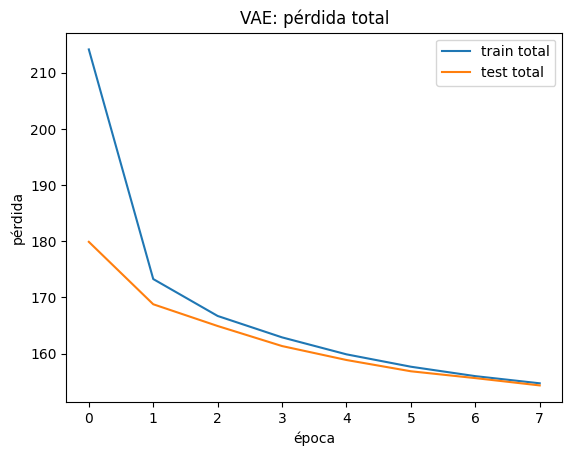

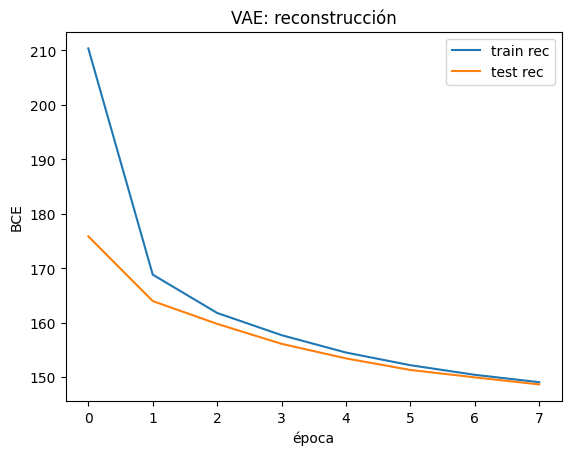

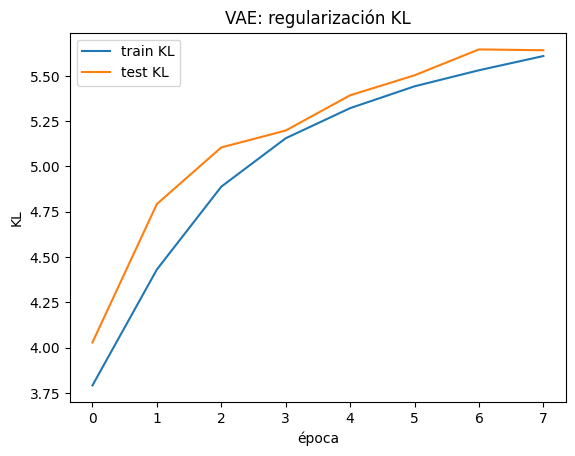

In [8]:
# Curvas: total, reconstrucción y KL
plt.plot(hist["train_total"], label="train total")
plt.plot(hist["test_total"], label="test total")
plt.xlabel("época"); plt.ylabel("pérdida")
plt.title("VAE: pérdida total")
plt.legend(); plt.show()

plt.plot(hist["train_rec"], label="train rec")
plt.plot(hist["test_rec"], label="test rec")
plt.xlabel("época"); plt.ylabel("BCE")
plt.title("VAE: reconstrucción")
plt.legend(); plt.show()

plt.plot(hist["train_kl"], label="train KL")
plt.plot(hist["test_kl"], label="test KL")
plt.xlabel("época"); plt.ylabel("KL")
plt.title("VAE: regularización KL")
plt.legend(); plt.show()

# Pregunta: ¿qué señal verías si hay 'posterior collapse'?


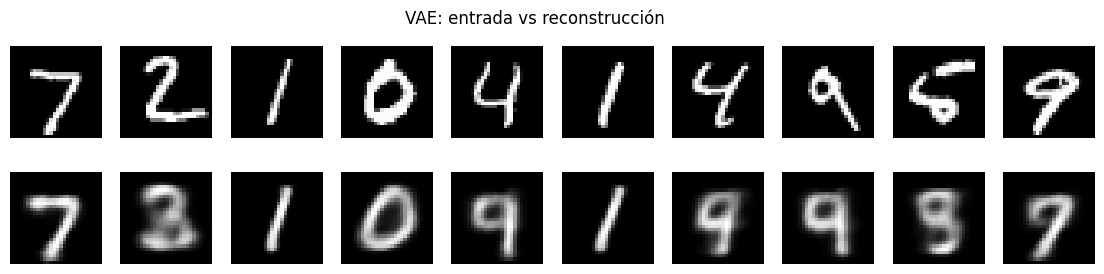

In [9]:
# Reconstrucciones
model.eval()
x, _ = next(iter(test_loader))
x = x[:10].to(device)

with torch.no_grad():
    xhat, mu, logvar, z = model(x)

x = x.cpu()
xhat = xhat.cpu()

fig, axes = plt.subplots(2, 10, figsize=(14, 3))
for i in range(10):
    axes[0, i].imshow(x[i,0], cmap="gray"); axes[0, i].axis("off")
    axes[1, i].imshow(xhat[i,0], cmap="gray"); axes[1, i].axis("off")
axes[0,0].set_ylabel("entrada"); axes[1,0].set_ylabel("reconstr.")
plt.suptitle("VAE: entrada vs reconstrucción")
plt.show()

# Pregunta: comparado con un AE, ¿esperas reconstrucciones mejores o peores? ¿por qué?


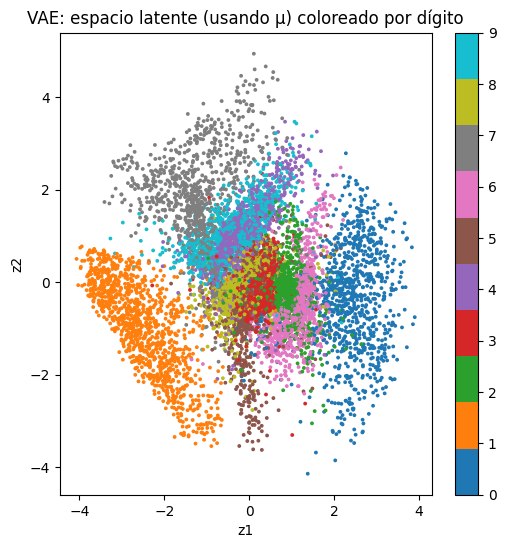

In [10]:
# Espacio latente (2D), coloreado por dígito (solo visual)
model.eval()
zs = []
ys = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        xhat, mu, logvar, z = model(x)
        # Para visualizar suele ser más estable usar mu
        zs.append(mu.cpu())
        ys.append(y)

Z = torch.cat(zs, dim=0).numpy()
Y = torch.cat(ys, dim=0).numpy()

plt.figure(figsize=(6, 6))
plt.scatter(Z[:,0], Z[:,1], c=Y, s=3, cmap="tab10")
plt.colorbar()
plt.title("VAE: espacio latente (usando μ) coloreado por dígito")
plt.xlabel("z1"); plt.ylabel("z2")
plt.show()

# Pregunta: ¿ves regiones del espacio que parezcan “vacías”?


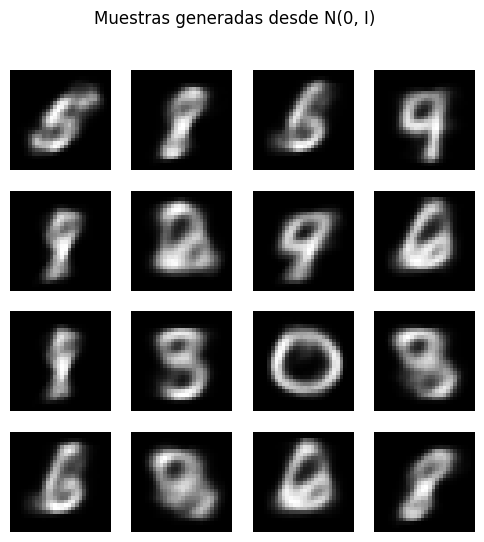

In [11]:
# Generación: muestrear z ~ N(0, I) y decodificar
model.eval()
n = 16
z = torch.randn(n, 2).to(device)

with torch.no_grad():
    samples = model.decode(z).cpu()

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
k = 0
for i in range(4):
    for j in range(4):
        axes[i, j].imshow(samples[k,0], cmap="gray")
        axes[i, j].axis("off")
        k += 1
plt.suptitle("Muestras generadas desde N(0, I)")
plt.show()

# Pregunta: ¿por qué ahora sí tiene sentido muestrear 'al azar'?


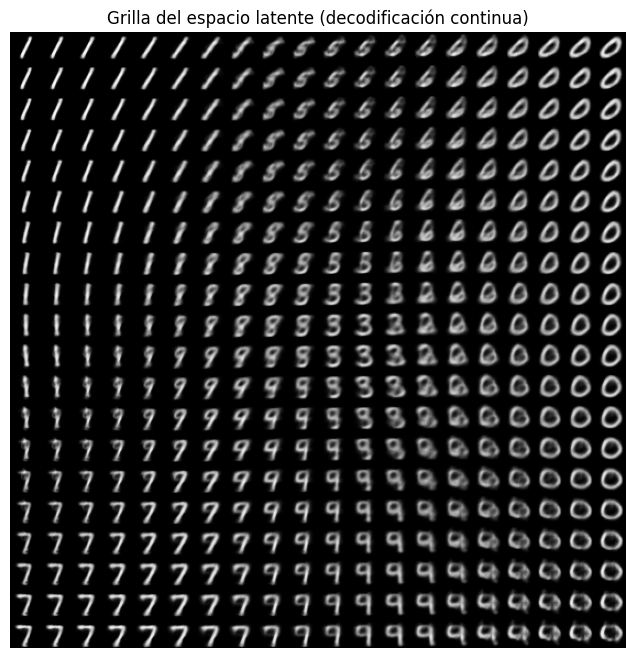

In [12]:
# (Opcional) Grilla 2D para ver continuidad del espacio latente
import numpy as np

grid_n = 20
grid_x = np.linspace(-2.5, 2.5, grid_n)
grid_y = np.linspace(-2.5, 2.5, grid_n)

canvas = torch.zeros((grid_n*28, grid_n*28))

with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            z = torch.tensor([[xj, yi]], dtype=torch.float32).to(device)
            img = model.decode(z).cpu()[0,0]
            canvas[i*28:(i+1)*28, j*28:(j+1)*28] = img

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap="gray")
plt.axis("off")
plt.title("Grilla del espacio latente (decodificación continua)")
plt.show()

# Pregunta: ¿qué te dice esta grilla sobre la “geometría” del espacio latente?


## Cierre

**Autoencoder (Sesión 9):** reconstruye, pero el latente puede ser difícil de muestrear.  
**VAE (Sesión 10):** impone un prior (Normal) y usa KL para lograr un latente continuo y generativo.

Pregunta final: **Si pudieras controlar una dimensión de z, ¿qué “factor” del dígito te gustaría controlar?**
